## Data from different sources

In this notebook, we will compare global temperature anomalies from two datasets:
- [ERA5 reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download) from **ECMWF**, available through the Climate Data Store.
- [HADCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.1.0.0/download.html), a dataset of global historical surface temperature anomalies from the **UK Met Office**, available on their website as a direct download.

We will then compare the anomalies from each of these datasets for **July 2024** - one of the hottest months on record globally.

### The bigger picture

This notebook demonstrates that we can get data from:
- Two different institutions (ECMWF and the UK Met Office)
- From two different source (CDS and URL)
- In two different formats (GRIB and netCDF)
- And that the earthkit ecosystem will treat them as "equal citizens", with earthkit tools working with the same API in both cases.

### Components of earthkit

This tutorial uses the following earthkit components - click any logo to open the package documentation:

<div align="center">
  <br>
  <a href="https://earthkit-data.readthedocs.io/en/latest/" target="_blank" style="display:inline-block; margin: 0 15px;">
    <img src="https://raw.githubusercontent.com/ecmwf/logos/refs/heads/main/logos/earthkit/earthkit-data-light.svg" alt="earthkit-data" width="200">
  </a>
  <a href="https://earthkit-transforms.readthedocs.io/en/latest/" target="_blank" style="display:inline-block; margin: 0 15px;">
    <img src="https://raw.githubusercontent.com/ecmwf/logos/refs/heads/main/logos/earthkit/earthkit-transforms-light.svg" alt="earthkit-transforms" width="200">
  </a>
  <a href="https://earthkit-plots.readthedocs.io/en/latest/" target="_blank" style="display:inline-block; margin: 0 15px;">
    <img src="https://raw.githubusercontent.com/ecmwf/logos/refs/heads/main/logos/earthkit/earthkit-plots-light.svg" alt="earthkit-plots" width="200">
  </a>
</div>

By importing `earthkit`, we get access to all of these tools with a single import.

In [1]:
import earthkit as ek

### 1. Getting the data

Let's do a comparison of the temperature anomalies for **July 2024** (one of the hottest months on record globally) from ERA5 and HADCRUT5.

#### 1.1 ERA5

In order to get temperature anomalies for July 2024 from ERA5, we need to acces the [ERA5 monthly averaged reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download) dataset from the CDS.

>In order to access ERA5 renalysis data, you will need an account on the Copernicus Climate Data Store (CDS). If you do not have an account, please visit [the CDS website](https://cds.climate.copernicus.eu/#!/home) and register for an account. Then, [follow these instructions](https://cds.climate.copernicus.eu/how-to-api) (step 1 only) to set up your API key.

HADCRUT5 data is an anomaly against the 1961-1991 average, so we need to retrieve:
- Data for every July from 1961-1991. This is our **reference period**.
- Data for July 2024, to calculate the anomaly.

In [2]:
era5_reference_data = ek.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": list(range(1961, 1991)),
        "month": "07",
        "time": "00:00",
    },
)

era5_2024_data = ek.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": 2024,
        "month": "07",
        "time": "00:00",
    },
)

2025-10-16 13:25:13,102 INFO Request ID is 96c2dbd0-f56b-4e61-bd9f-7029b213ce70
2025-10-16 13:25:13,276 INFO status has been updated to accepted
2025-10-16 13:25:27,721 INFO status has been updated to successful
2025-10-16 13:26:30,295 INFO Request ID is 9a002cb7-9d57-4285-b501-cd9aa8ba2e4d
2025-10-16 13:26:30,421 INFO status has been updated to accepted
2025-10-16 13:26:39,167 INFO status has been updated to running
2025-10-16 13:26:44,312 INFO status has been updated to successful


#### 1.2 HADCRUT5

The HADCRUT5 dataset is available on the [Met Office's dedicated website](https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.1.0.0/download.html). We can access the gridded monthly dataset directly from a URL. 

In [3]:
HADCRUT5_URL = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc"
hadcrut5_data = ek.data.from_source("url", HADCRUT5_URL)

### 2. Data analysis

#### 2.1 ERA5

Now we need to do some analysis with earthkit-transforms to calculate the ERA5 temperature anomalies.

First, let's convert the GRIB data that we retrieved from the CDS to xarray.

In [4]:
reference = era5_reference_data.to_xarray()
july_2024 = era5_2024_data.to_xarray(ensure_dims="forecast_reference_time")

Now let's calculate a climatology from the reference data, and use it to calculate an anomaly for July 2024.

In [5]:
climatology = ek.transforms.climatology.mean(reference, frequency="month")
climatology

<xarray.Dataset> Size: 8MB
Dimensions:    (month: 1, latitude: 721, longitude: 1440)
Coordinates:
  * month      (month) int64 8B 7
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    2t         (month, latitude, longitude) float64 8MB 274.0 274.0 ... 218.5
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       moda
    levtype:      sfc
    type:         an
    ...           ...
    date:         19610701
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

We calculate anomalies by finding the difference between some data at a point in time against the long-term average. Our *climatology* is our long-term average, and earthkit-transforms provides an `anomaly` method for conveniently calculating the difference between the two.

In [6]:
era5_july_anomaly = ek.transforms.climatology.anomaly(july_2024, climatology)

#### 2.2 HADCRUT5
As for HADCRUT5, this data is already anomalies - so we just need to extract July 2024.

In [7]:
hadcrut5 = hadcrut5_data.to_xarray()
hadcrut5

<xarray.Dataset> Size: 44MB
Dimensions:           (time: 2102, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2025...
  * latitude          (latitude) float64 288B -87.5 -82.5 -77.5 ... 82.5 87.5
  * longitude         (longitude) float64 576B -177.5 -172.5 ... 172.5 177.5
    realization       int64 8B ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 44MB dask.array<chunksize=(1, 36, 72), meta=np.ndarray>
    time_bnds         (time, bnds) datetime64[ns] 34kB dask.array<chunksize=(2102, 2), meta=np.ndarray>
    latitude_bnds     (latitude, bnds) float64 576B dask.array<chunksize=(36, 2), meta=np.ndarray>
    longitude_bnds    (longitude, bnds) float64 1kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    realization_bnds  (bnds) int64 16B dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2025-04-30T17:33:58+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.2.0 HadSST.4.0.1.0
    title:        HadCRUT.5.0.2.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.2.0
    Conventions:  CF-1.7

In [8]:
hadcrut5_july_anomaly = hadcrut5.tas_mean.sel(time="2024-07-16")
hadcrut5_july_anomaly

<xarray.DataArray 'tas_mean' (time: 1, latitude: 36, longitude: 72)> Size: 21kB
dask.array<getitem, shape=(1, 36, 72), dtype=float64, chunksize=(1, 36, 72), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2024-07-16T12:00:00
  * latitude     (latitude) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude    (longitude) float64 576B -177.5 -172.5 -167.5 ... 172.5 177.5
    realization  int64 8B ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

### 3. Visualisation

We can use earthkit-plots to visualise these two datasets using the same principles.

First, let's design a suitable style for these anomalies.

In [9]:
style = ek.plots.styles.Contour(
    colors=[
        "#1B2C62", "#1F4182", "#2355A1", "#3978BB", "#519BD2", "#71B8E4",
        "#91D1F2", "#B0E1F8", "#CBEBF9", "#E3F4FB", "#F5FBFE", "#FEFBEA",
        "#FDF2BC", "#FCE18A", "#FDC659", "#FDA731", "#F9872D", "#F26429",
        "#E34128", "#D01F27", "#B31A21", "#921519",
    ],
    levels=range(-7, 8),
    ticks=range(-7, 8),
    extend="both",
    # the data is in Kelvin but we want to show celsius in the legend
    # if we use the `units` key it will attempt to convert units to C
    # units_label lets us just override the label
    units_label="°C",
)

Now we can plot them!

<Figure size 800x550 with 0 Axes>

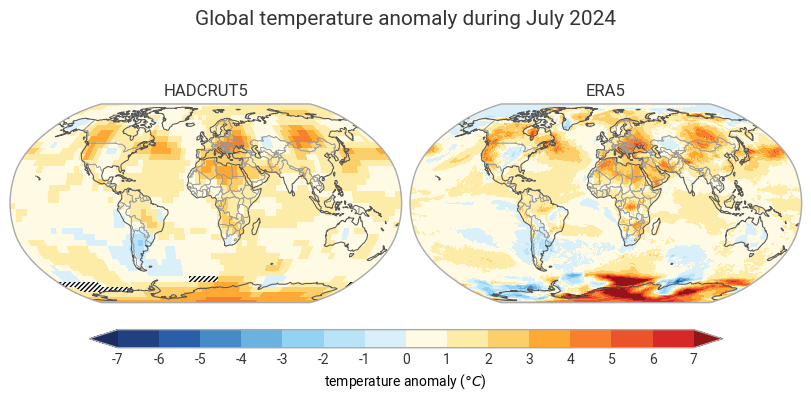

In [10]:
import cartopy.crs as ccrs

figure = ek.plots.Figure(crs=ccrs.Robinson(), rows=1, columns=2, size=(8, 5.5))

# We can throw both datasets at the figure and it will iterate over subplots to plot them
figure.pcolormesh([hadcrut5_july_anomaly, era5_july_anomaly], style=style)

figure.coastlines(resolution="low")
figure.borders(resolution="low")

figure.legend(label="temperature anomaly ({units})")

# Add titles
figure[0].title("HADCRUT5")
figure[1].title("ERA5")
# We can use the "time" key once here as it should have the same value for ERA5 and HADCRUT5
figure.title("Global temperature anomaly during {time:%B %Y}", fontsize=15)

# Add shading to emphasise the missing data in HADCRUT5
# We can directly access the underlying matplotlib objects to do this
x = [-180, -180, 180, 180, -180]
y = [-90, 90, 90, -90, -90]
figure[0].ax.fill(x, y, transform=ccrs.PlateCarree(), hatch="///////", fill=False, zorder=0)

figure.show()

### Exercises

1. Now that you have compared July 2024 between HADCRUT5 and ERA5, can you do the same for another month and/or year?
1. Can you show a zoomed-in version of this comparison over Europe?

#### 1. Now that you have compared July 2024 between HADCRUT5 and ERA5, can you do the same for another month and/or year?

We will need to do a new retrieval of ERA5 from the CDS. This time, we need all the Januaries from 1961-1991 as our reference period, and January 2025 for our anomaly.

In [11]:
era5_reference_data = ek.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": list(range(1961, 1991)),
        "month": "01",
        "time": "00:00",
    },
)

era5_2025_data = ek.data.from_source(
    "cds", "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": "2m_temperature",
        "year": 2025,
        "month": "01",
        "time": "00:00",
    },
)

2025-10-16 13:27:01,611 INFO Request ID is e256c194-d10d-4304-be7d-ce93e0a3adeb
2025-10-16 13:27:01,686 INFO status has been updated to accepted
2025-10-16 13:27:15,253 INFO status has been updated to running
2025-10-16 13:27:22,976 INFO status has been updated to successful
2025-10-16 13:27:26,392 INFO Request ID is 267b07a7-b82a-403a-b8b8-4098c69364a0                                                                               
2025-10-16 13:27:26,443 INFO status has been updated to accepted
2025-10-16 13:27:47,777 INFO status has been updated to successful


Now let's do the anomaly calculations:

In [12]:
reference = era5_reference_data.to_xarray()
jan_2025 = era5_2025_data.to_xarray(ensure_dims="forecast_reference_time")

climatology = ek.transforms.climatology.mean(reference, frequency="month")
era5_jan_anomaly = ek.transforms.climatology.anomaly(jan_2025, climatology)

For HADCRUT5, we simply need to extract January 2025 from the dataset:

In [13]:
hadcrut5_jan_anomaly = hadcrut5.tas_mean.sel(time="2025-01-16")

And finally, we can plot this data using the exact same code as before (we don't even need to update the title, as the date is extracted from the metadata!).

<Figure size 800x550 with 0 Axes>

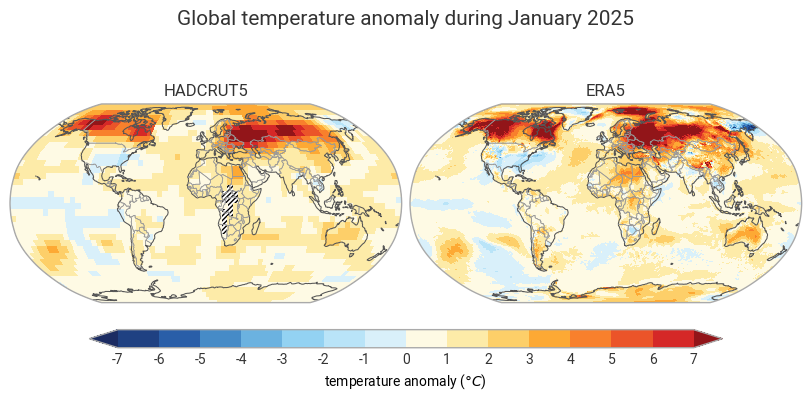

In [14]:
figure = ek.plots.Figure(crs=ccrs.Robinson(), rows=1, columns=2, size=(8, 5.5))

# We can throw both datasets at the figure and it will iterate over subplots to plot them
figure.pcolormesh([hadcrut5_jan_anomaly, era5_jan_anomaly], style=style)

figure.coastlines(resolution="low")
figure.borders(resolution="low")

figure.legend(label="temperature anomaly ({units})")

# Add titles
figure[0].title("HADCRUT5")
figure[1].title("ERA5")
# We can use the "time" key once here as it should have the same value for ERA5 and HADCRUT5
figure.title("Global temperature anomaly during {time:%B %Y}", fontsize=15)

# Add shading to emphasise the missing data in HADCRUT5
# We can directly access the underlying matplotlib objects to do this
x = [-180, -180, 180, 180, -180]
y = [-90, 90, 90, -90, -90]
figure[0].ax.fill(x, y, transform=ccrs.PlateCarree(), hatch="///////", fill=False, zorder=0)

figure.show()

#### 2. Can you show a zoomed-in version of this comparison over Europe?

We can do this by simply replacing the `crs` argument with a `domain` argument.

<Figure size 800x550 with 0 Axes>

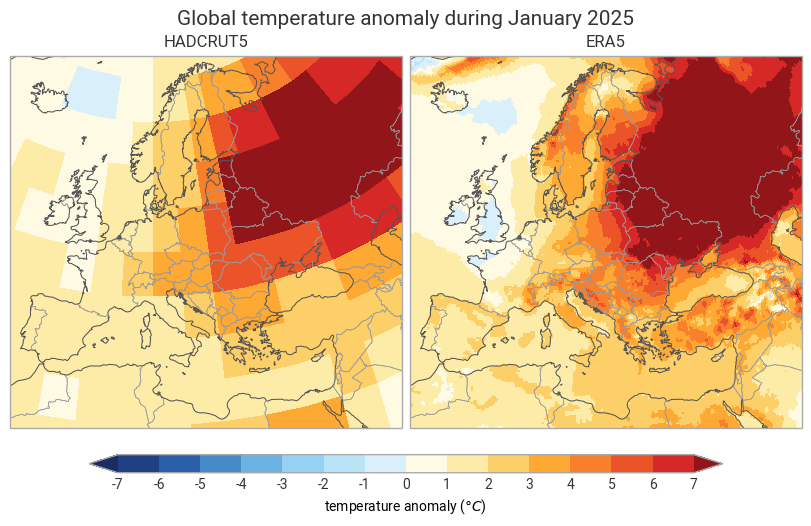

In [15]:
figure = ek.plots.Figure(domain="Europe", rows=1, columns=2, size=(8, 5.5))

# We can throw both datasets at the figure and it will iterate over subplots to plot them
figure.pcolormesh([hadcrut5_jan_anomaly, era5_jan_anomaly], style=style)

figure.coastlines(resolution="medium")
figure.borders(resolution="medium")

figure.legend(label="temperature anomaly ({units})")

# Add titles
figure[0].title("HADCRUT5")
figure[1].title("ERA5")
# We can use the "time" key once here as it should have the same value for ERA5 and HADCRUT5
figure.title("Global temperature anomaly during {time:%B %Y}", fontsize=15)

# Add shading to emphasise the missing data in HADCRUT5
# We can directly access the underlying matplotlib objects to do this
x = [-180, -180, 180, 180, -180]
y = [-90, 90, 90, -90, -90]
figure[0].ax.fill(x, y, transform=ccrs.PlateCarree(), hatch="///////", fill=False, zorder=0)

figure.show()